# **Importing Data**

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import InceptionV3
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.preprocessing import image
import os
import PIL
from PIL import Image
from IPython.display import display
from glob import glob
import random
import cv2
import warnings
warnings.simplefilter('ignore')

In [3]:
import zipfile
zip_path = '/content/Data_train.zip'
extract_path = '/content/Data_training'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [4]:
import zipfile
zip_path = '/content/Data_valid.zip'
extract_path = '/content/Data_valid'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [5]:
import zipfile
zip_path = '/content/Data_test.zip'
extract_path = '/content/Data_test'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [6]:
def get_all_image_paths_and_labels(root_dir, class_names):
    image_paths = []
    labels = []

    for label, class_name in enumerate(class_names):
        class_path = os.path.join(root_dir, class_name)
        pattern = os.path.join(class_path, '**', '*.[jJpP][pPnN][gG]')
        class_images = glob(pattern, recursive=True)

        image_paths.extend(class_images)
        labels.extend([label] * len(class_images))

    return image_paths, labels

def preprocess_image(file_path, label, img_size=(224, 224)):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, img_size)
    image = image / 255.0
    return image, label

def create_dataset_from_nested_folders(root_dir, class_names, img_size=(224, 224), batch_size=32, shuffle=True):
    image_paths, labels = get_all_image_paths_and_labels(root_dir, class_names)

    if shuffle:
        combined = list(zip(image_paths, labels))
        random.shuffle(combined)
        image_paths, labels = zip(*combined)

    path_ds = tf.data.Dataset.from_tensor_slices((list(image_paths), list(labels)))
    image_ds = path_ds.map(lambda x, y: preprocess_image(x, y, img_size), num_parallel_calls=tf.data.AUTOTUNE)

    image_ds = image_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return image_ds


In [7]:
import os
import shutil
import random

def get_unique_filename(dst_path):
    base, ext = os.path.splitext(dst_path)
    i = 1
    while os.path.exists(dst_path):
        dst_path = f"{base}_{i}{ext}"
        i += 1
    return dst_path

def flatten_and_shuffle(class_dir):
    # Flatten
    for root, dirs, files in os.walk(class_dir):
        if root == class_dir:
            continue
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                src = os.path.join(root, file)
                dst = os.path.join(class_dir, file)
                dst = get_unique_filename(dst)
                shutil.move(src, dst)
                print(f"Đã move: {src} --> {dst}")

    for root, dirs, _ in os.walk(class_dir, topdown=False):
        for d in dirs:
            dir_path = os.path.join(root, d)
            try:
                os.rmdir(dir_path)
                print(f"Đã xoá thư mục rỗng: {dir_path}")
            except:
                pass

    image_files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    random.shuffle(image_files)

    for idx, filename in enumerate(image_files):
        old_path = os.path.join(class_dir, filename)
        ext = os.path.splitext(filename)[1]
        new_filename = f"img_{idx:05d}{ext}"
        new_path = os.path.join(class_dir, new_filename)
        os.rename(old_path, new_path)
        print(f"Đã đổi tên: {old_path} --> {new_path}")

flatten_and_shuffle("/content/Data_training/Data_train/Japanese")
flatten_and_shuffle("/content/Data_training/Data_train/Other")
flatten_and_shuffle("/content/Data_training/Data_train/Vietnamese")



Streaming output truncated to the last 5000 lines.
Đã đổi tên: /content/Data_training/Data_train/Vietnamese/img_05904.png --> /content/Data_training/Data_train/Vietnamese/img_19000.png
Đã đổi tên: /content/Data_training/Data_train/Vietnamese/img_07998.png --> /content/Data_training/Data_train/Vietnamese/img_19001.png
Đã đổi tên: /content/Data_training/Data_train/Vietnamese/495_5.png --> /content/Data_training/Data_train/Vietnamese/img_19002.png
Đã đổi tên: /content/Data_training/Data_train/Vietnamese/img_00421.png --> /content/Data_training/Data_train/Vietnamese/img_19003.png
Đã đổi tên: /content/Data_training/Data_train/Vietnamese/294_10.png --> /content/Data_training/Data_train/Vietnamese/img_19004.png
Đã đổi tên: /content/Data_training/Data_train/Vietnamese/246_1.png --> /content/Data_training/Data_train/Vietnamese/img_19005.png
Đã đổi tên: /content/Data_training/Data_train/Vietnamese/img_09402.png --> /content/Data_training/Data_train/Vietnamese/img_19006.png
Đã đổi tên: /content/D

In [8]:
import os
import shutil

def get_unique_filename(dst_path):
    base, ext = os.path.splitext(dst_path)
    i = 1
    while os.path.exists(dst_path):
        dst_path = f"{base}_{i}{ext}"
        i += 1
    return dst_path

def flatten_subfolders(class_dir):
    for root, dirs, files in os.walk(class_dir):
        if root == class_dir:
            continue
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                src = os.path.join(root, file)
                dst = os.path.join(class_dir, file)
                dst = get_unique_filename(dst)
                shutil.move(src, dst)
                print(f"Đã move: {src} --> {dst}")

    for root, dirs, _ in os.walk(class_dir, topdown=False):
        for d in dirs:
            dir_path = os.path.join(root, d)
            try:
                os.rmdir(dir_path)
                print(f"Đã xoá thư mục rỗng: {dir_path}")
            except:
                pass

flatten_subfolders("/content/Data_valid/Data_val/Vietnamese")
flatten_subfolders("/content/Data_valid/Data_val/Japanese")
flatten_subfolders("/content/Data_valid/Data_val/Other")

Đã move: /content/Data_valid/Data_val/Japanese/Shintaro+Ikeda/56.jpg --> /content/Data_valid/Data_val/Japanese/56_14.jpg
Đã move: /content/Data_valid/Data_val/Japanese/Shintaro+Ikeda/67.jpg --> /content/Data_valid/Data_val/Japanese/67_8.jpg
Đã move: /content/Data_valid/Data_val/Japanese/Shintaro+Ikeda/64.jpg --> /content/Data_valid/Data_val/Japanese/64_16.jpg
Đã move: /content/Data_valid/Data_val/Japanese/Shintaro+Ikeda/47.jpg --> /content/Data_valid/Data_val/Japanese/47_24.jpg
Đã move: /content/Data_valid/Data_val/Japanese/Shintaro+Ikeda/37.jpg --> /content/Data_valid/Data_val/Japanese/37_16.jpg
Đã move: /content/Data_valid/Data_val/Japanese/Shintaro+Ikeda/21.jpg --> /content/Data_valid/Data_val/Japanese/21_24.jpg
Đã move: /content/Data_valid/Data_val/Japanese/Shintaro+Ikeda/31.jpg --> /content/Data_valid/Data_val/Japanese/31_13.jpg
Đã move: /content/Data_valid/Data_val/Japanese/Shintaro+Ikeda/18.jpg --> /content/Data_valid/Data_val/Japanese/18_23.jpg
Đã move: /content/Data_valid/Data

In [9]:
import tensorflow as tf
train_dir = "/content/Data_training/Data_train"
val_dir = "/content/Data_valid/Data_val"
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    class_names=['Japanese', 'Other', 'Vietnamese'],
    image_size=(224, 224),
    batch_size=32,
    shuffle=True
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='int',
    class_names=['Japanese', 'Other', 'Vietnamese'],
    image_size=(224, 224),
    batch_size=32,
    shuffle=True
)

Found 48198 files belonging to 3 classes.
Found 9494 files belonging to 3 classes.


In [10]:
import numpy as np
import matplotlib.pyplot as plt

def plot_dist(train_dataset, class_names):
    class_counts = np.zeros(len(class_names))
    for images, labels in train_dataset:
        labels = labels.numpy().flatten()
        for label in labels:
            class_counts[label] += 1

    plt.figure(figsize=(10, 5))
    plt.bar(class_names, class_counts)
    plt.title('Class Distribution in Training Dataset')
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.show()





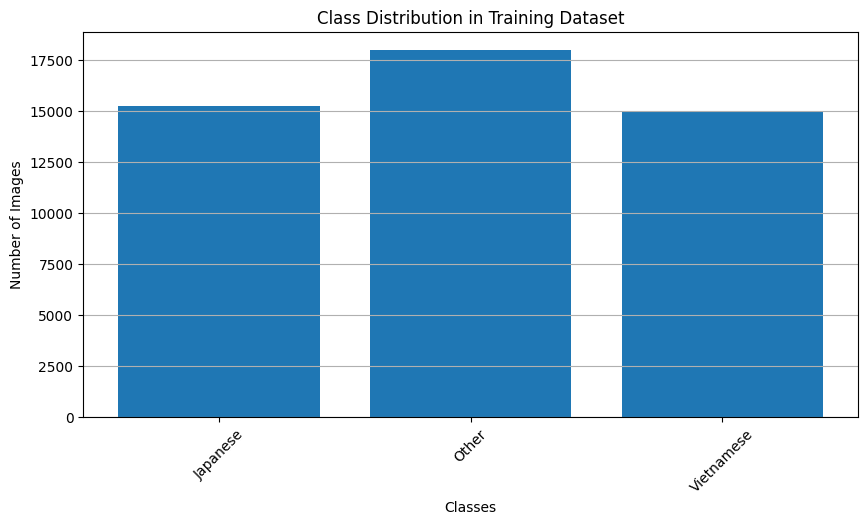

In [11]:
class_names_to_include = ['Japanese', 'Other', 'Vietnamese']
plot_dist(train_dataset, class_names_to_include)


In [12]:
import numpy as np
import matplotlib.pyplot as plt

def plot_distval(val_dataset, class_names):
    class_counts = np.zeros(len(class_names))
    for images, labels in val_dataset:
        # Convert labels to numpy array and flatten it
        labels = labels.numpy().flatten()
        for label in labels:
            class_counts[label] += 1

    plt.figure(figsize=(10, 5))
    plt.bar(class_names, class_counts)
    plt.title('Class Distribution in valid Dataset')
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.show()





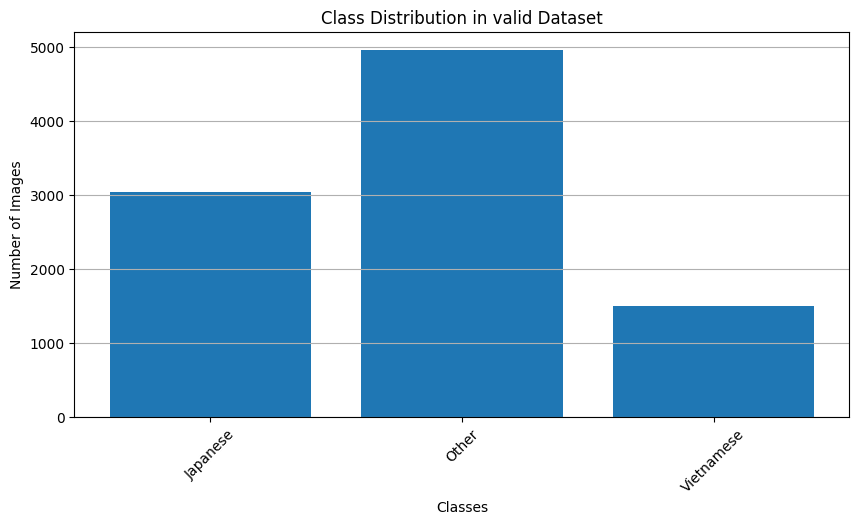

In [13]:
plot_distval(val_dataset, class_names_to_include)


**We have balanced class except for white we have more data**

In [14]:
# Getting the first batch of data
for images, labels in train_dataset.take(1):
    print("Images shape:", images.shape)  # Shape of the images
    print("Labels shape:", labels.shape)   # Shape of the labels
    print("Batch of images:", images.numpy())  # Array of image data
    print("Batch of labels:", labels.numpy())  # Corresponding labels


Images shape: (32, 224, 224, 3)
Labels shape: (32,)
Batch of images: [[[[1.01000000e+02 1.00000000e+02 8.30000000e+01]
   [9.38125000e+01 9.42500000e+01 8.08437500e+01]
   [8.51562500e+01 8.66875000e+01 7.68125000e+01]
   ...
   [2.23593750e+02 2.15593750e+02 1.54062500e+02]
   [2.21156250e+02 2.13156250e+02 1.53000000e+02]
   [2.19000000e+02 2.11000000e+02 1.53000000e+02]]

  [[8.80625000e+01 8.70625000e+01 7.07812500e+01]
   [7.88085938e+01 7.87294922e+01 6.60419922e+01]
   [7.01074219e+01 7.09199219e+01 6.17636719e+01]
   ...
   [2.24312500e+02 2.15975586e+02 1.56218750e+02]
   [2.20864258e+02 2.12751953e+02 1.54145508e+02]
   [2.16125000e+02 2.09562500e+02 1.51562500e+02]]

  [[7.98125000e+01 7.88125000e+01 6.38750000e+01]
   [6.70771484e+01 6.71777344e+01 5.54521484e+01]
   [5.73125000e+01 5.80927734e+01 4.97490234e+01]
   ...
   [2.27216797e+02 2.18748047e+02 1.61561523e+02]
   [2.23937500e+02 2.15631836e+02 1.59225586e+02]
   [2.18187500e+02 2.11656250e+02 1.55250000e+02]]

  ..

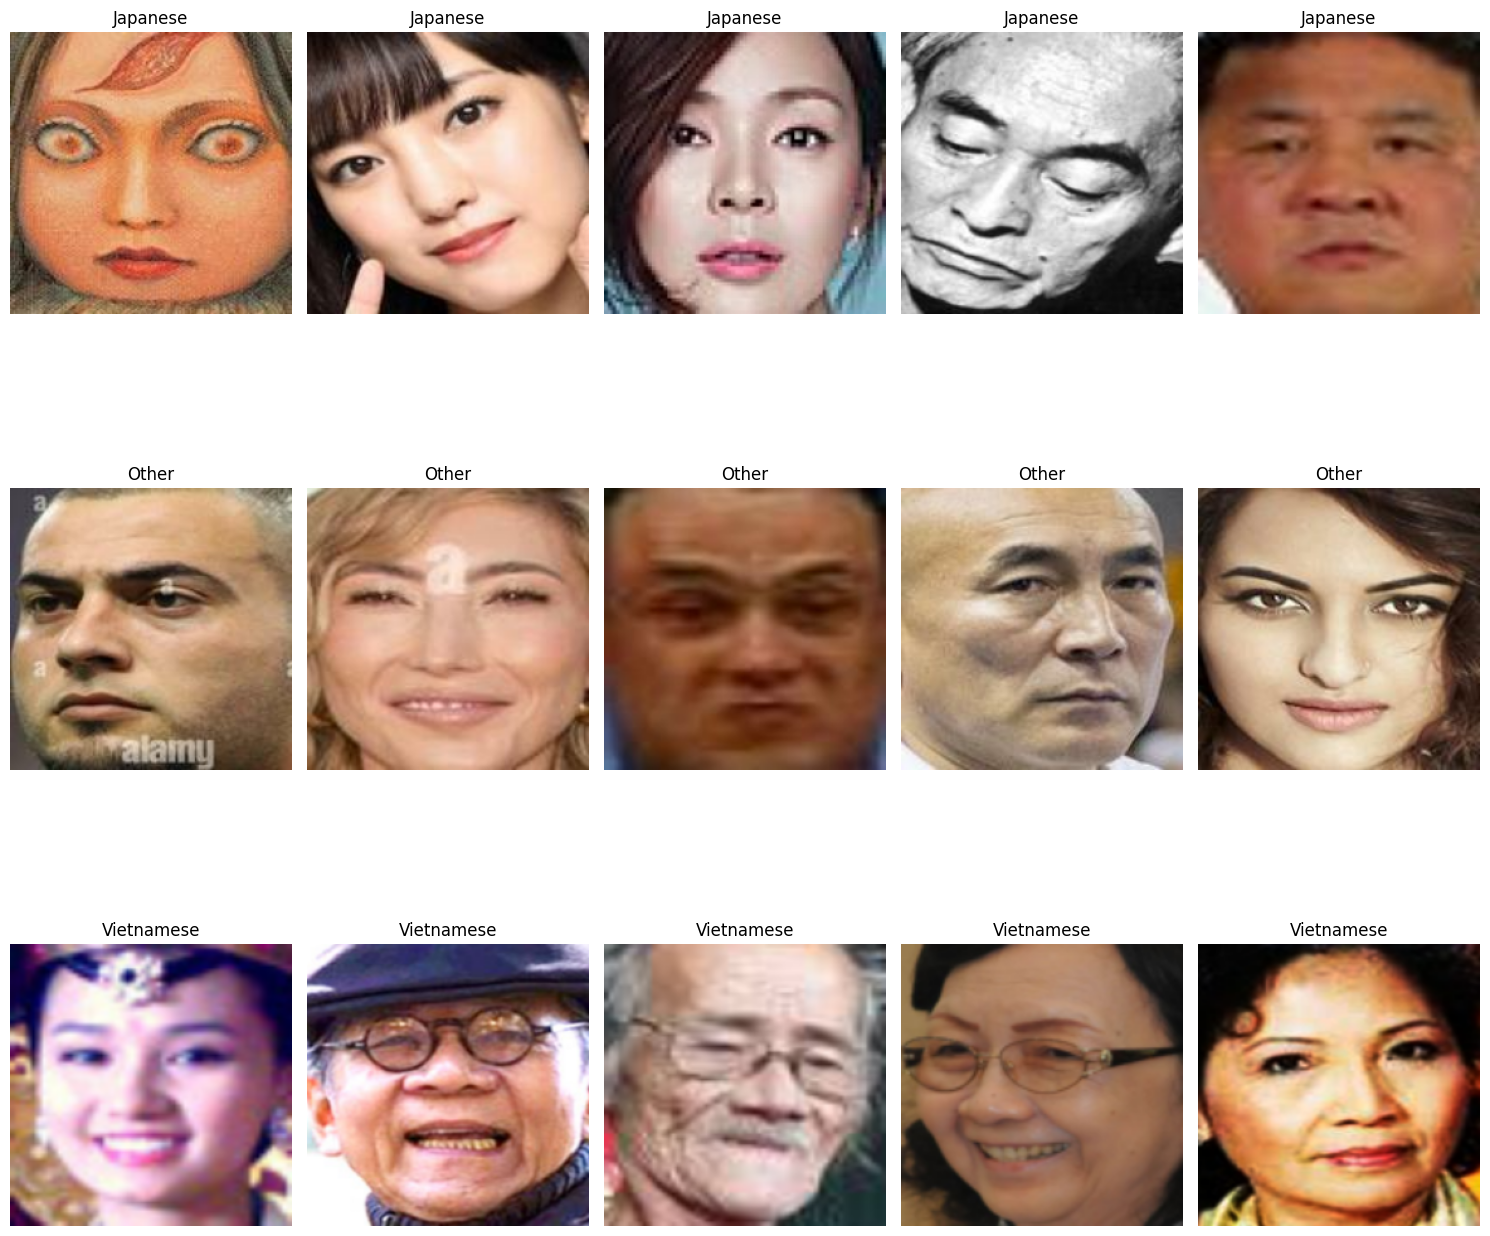

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot a few images from each class
def plot_images_from_each_class(dataset, class_names, num_images=5):
    # Create a dictionary to store images from each class
    class_images = {class_name: [] for class_name in class_names}

    # Iterate through the dataset to collect images from each class
    for images, labels in dataset.take(100):  # Limit the number of batches for efficiency
        for i, label in enumerate(labels):
            class_name = class_names[label]
            if len(class_images[class_name]) < num_images:
                # Add image to the corresponding class
                image_array = images[i].numpy()
#                 image_array = (image_array * 255).astype('uint8')
                class_images[class_name].append(image_array)

        # Stop when we have enough images for each class
        if all(len(class_images[class_name]) >= num_images for class_name in class_names):
            break

    # Plot the images from each class
    plt.figure(figsize=(15, 15))
    for i, class_name in enumerate(class_names):
        for j in range(num_images):
            plt.subplot(len(class_names), num_images, i * num_images + j + 1)
            plt.imshow(class_images[class_name][j].astype('uint8'))  # Ensure correct data type for display
            plt.title(class_name)
            plt.axis('off')

    plt.tight_layout()
    plt.show()


# Call the function to plot images from each class
plot_images_from_each_class(train_dataset, class_names_to_include)




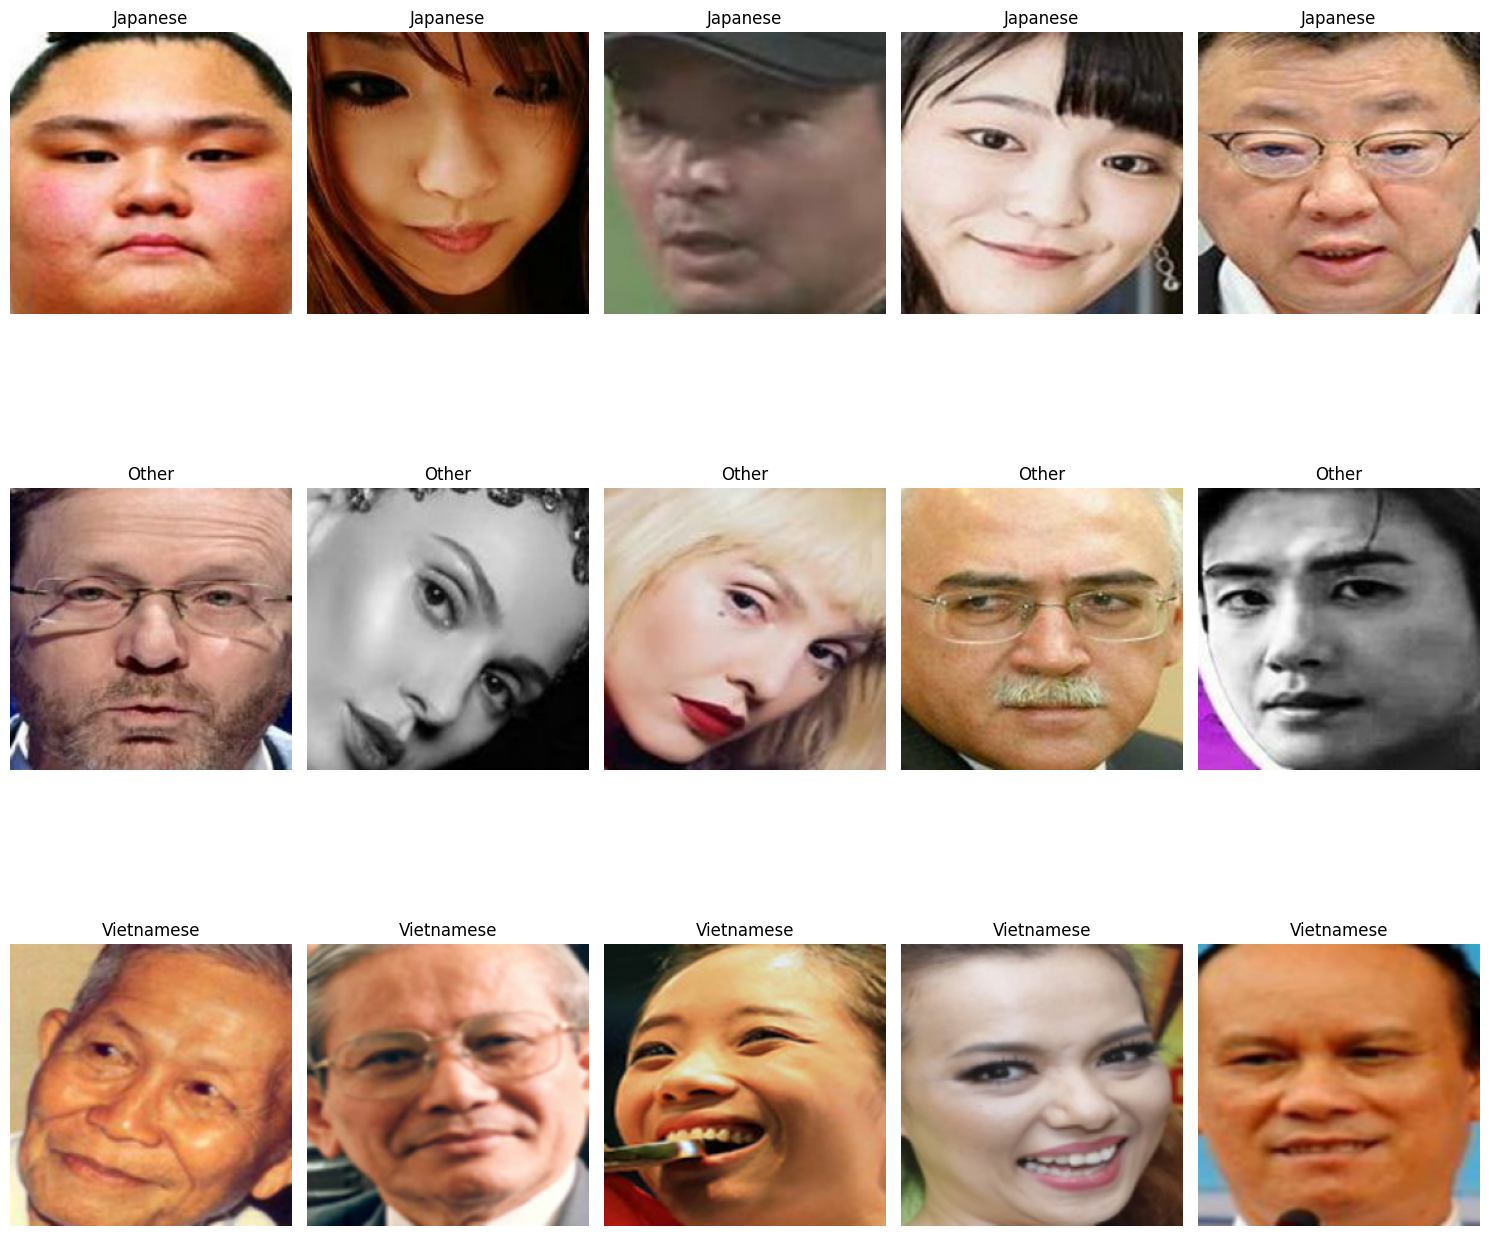

In [16]:
plot_images_from_each_class(val_dataset, class_names_to_include)

# **Training CNN**

In [17]:
def confusion(model) :
    val_images, val_labels = next(iter(val_dataset))
    predictions = np.argmax(model.predict(val_images), axis=1)
    cm = confusion_matrix(val_labels, predictions)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names_to_include, yticklabels=class_names_to_include)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


In [18]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [19]:
from tensorflow.keras.layers import Rescaling
train_dataset = train_dataset.map(lambda x, y: (Rescaling(1./255)(x), y))
val_dataset = val_dataset.map(lambda x, y: (Rescaling(1./255)(x), y))


In [20]:
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False
    for layer in base_model.layers[-50:]:  # Unfreeze the last 20 layers
            layer.trainable = True
    last_layer = base_model.get_layer('mixed10')
    last_output = last_layer.output
    x = GlobalAveragePooling2D()(last_output)
    x = Dense(1024, activation='relu')(x)
    x = Dense(3, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=x)

In [20]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [21]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=15,
    callbacks=[early_stopping]
)

Epoch 1/15
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 145s 99ms/step - accuracy: 0.7576 - loss: 0.5874 - val_accuracy: 0.7793 - val_loss: 0.5616
Epoch 2/15
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 102s 84ms/step - accuracy: 0.8569 - loss: 0.3421 - val_accuracy: 0.8445 - val_loss: 0.3721
Epoch 3/15
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 100s 83ms/step - accuracy: 0.8823 - loss: 0.2843 - val_accuracy: 0.8130 - val_loss: 0.5066
Epoch 4/15
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 142s 83ms/step - accuracy: 0.9045 - loss: 0.2266 - val_accuracy: 0.8215 - val_loss: 0.4648
Epoch 5/15
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 144s 85ms/step - accuracy: 0.9279 - loss: 0.1823 - val_accuracy: 0.8330 - val_loss: 0.5144


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


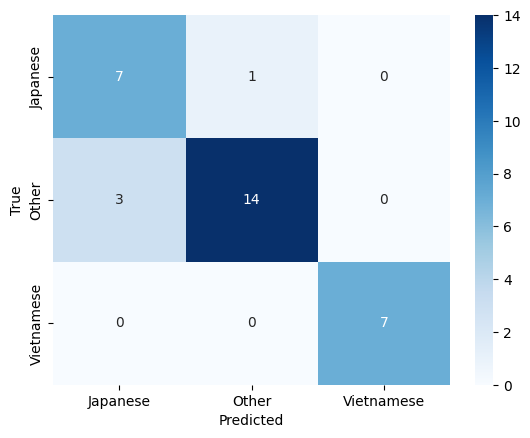

In [22]:
confusion(model)


In [23]:
model.save('race_classification_model.h5')

In [21]:
model = tf.keras.models.load_model("/content/race_classification_model.h5")

In [22]:
from sklearn.metrics import classification_report
import numpy as np

y_true = []
y_pred = []

for images, labels in val_dataset:
    preds = model.predict(images)
    preds_classes = np.argmax(preds, axis=1)
    y_pred.extend(preds_classes)
    y_true.extend(labels.numpy())

print("\n📊 Classification Report (Validation):")
print(classification_report(y_true, y_pred, target_names=class_names_to_include))


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


In [26]:
def plot_loss(history) :
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

    # Evaluate the model
    val_loss, val_accuracy = model.evaluate(val_dataset, verbose=1)
    print(f"Validation Loss: {val_loss}")
    print(f"Validation Accuracy: {val_accuracy}")

In [27]:
def plot_acc(history) :
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

    # Evaluate the model
    val_loss, val_accuracy = model.evaluate(val_dataset, verbose=1)
    print(f"Validation Loss: {val_loss}")
    print(f"Validation Accuracy: {val_accuracy}")

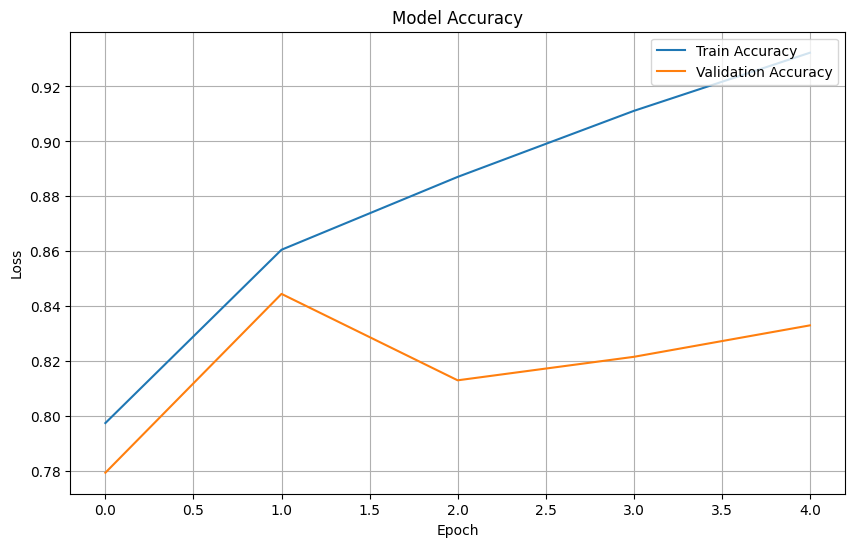

172/172 ━━━━━━━━━━━━━━━━━━━━ 20s 78ms/step - accuracy: 0.8503 - loss: 0.3576
Validation Loss: 0.37207987904548645
Validation Accuracy: 0.8444606065750122


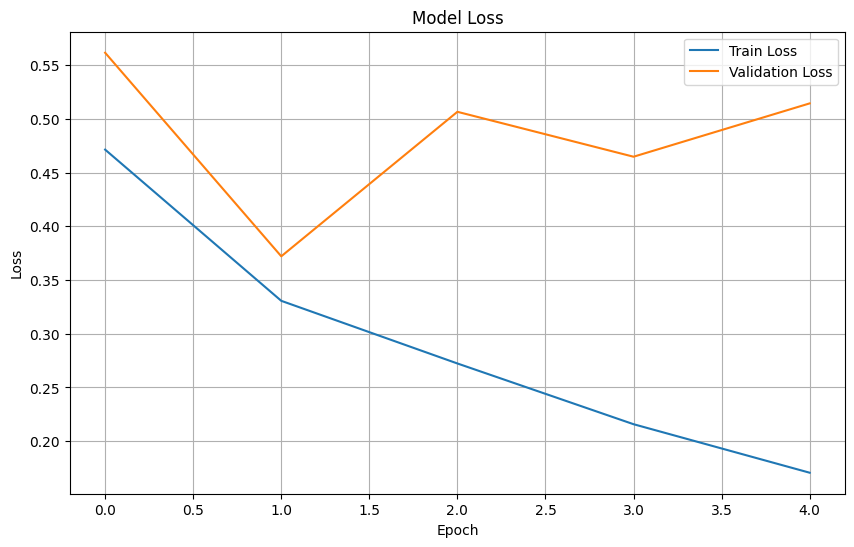

172/172 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.8557 - loss: 0.3510
Validation Loss: 0.3720797002315521
Validation Accuracy: 0.8444606065750122


In [28]:
plot_acc(history)
plot_loss(history)

In [ ]:
import os
import shutil
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report, confusion_matrix


def get_unique_filename(dst_path):
    base, ext = os.path.splitext(dst_path)
    i = 1
    while os.path.exists(dst_path):
        dst_path = f"{base}_{i}{ext}"
        i += 1
    return dst_path

def flatten_subfolders_with_labels(class_dir, label_output_path="test_image_labels.csv"):
    image_labels = []

    for root, dirs, files in os.walk(class_dir):
        if root == class_dir:
            continue
        label = os.path.basename(root)
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                src = os.path.join(root, file)
                dst = os.path.join(class_dir, file)
                dst = get_unique_filename(dst)
                shutil.move(src, dst)
                new_filename = os.path.basename(dst)
                image_labels.append((new_filename, label))
                print(f"Đã move: {src} --> {dst}")

    with open(label_output_path, mode='w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["filename", "label"])
        writer.writerows(image_labels)


    for root, dirs, _ in os.walk(class_dir, topdown=False):
        for d in dirs:
            try:
                os.rmdir(os.path.join(root, d))
            except:
                pass


def load_labels_from_csv(label_csv_path):
    labels = {}
    with open(label_csv_path, mode='r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            labels[row['filename']] = row['label']
    return labels


def predict_and_evaluate(image_directory, model, class_names_to_include, ground_truth_labels, batch_size=32, visualize=False):
    image_files = [f for f in os.listdir(image_directory) if f.lower().endswith(('jpg', 'jpeg', 'png'))]
    images = []
    filenames = []

    for image_file in image_files:
        img_path = os.path.join(image_directory, image_file)
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img) / 255.0
        images.append(img_array)
        filenames.append(image_file)

    images_np = np.array(images)

    predictions = model.predict(images_np, batch_size=batch_size, verbose=1)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = [class_names_to_include.index(ground_truth_labels[fn]) for fn in filenames]


    correct_predictions = sum([1 for i, pred in enumerate(predicted_classes) if pred == true_classes[i]])
    accuracy = correct_predictions / len(images_np)
    print(f"\nAccuracy: {accuracy * 100:.2f}%")

    # Precision, Recall, F1
    print("\n📊 Classification Report:")
    print(classification_report(true_classes, predicted_classes, target_names=class_names_to_include))

    # Confusion matrix
    cm = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names_to_include,
                yticklabels=class_names_to_include)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    if visualize:
        for i, image_file in enumerate(image_files):
            predicted_label = class_names_to_include[predicted_classes[i]]
            actual_label = ground_truth_labels.get(image_file)
            if predicted_label != actual_label:
                img_path = os.path.join(image_directory, image_file)
                img = image.load_img(img_path, target_size=(224, 224))
                plt.imshow(img)
                plt.title(f'Predicted: {predicted_label} | Actual: {actual_label}')
                plt.axis('off')
                plt.show()

image_directory = '/content/Data_test/Data_test'
label_csv_path = 'test_image_labels.csv'

flatten_subfolders_with_labels(image_directory, label_csv_path)
ground_truth_labels = load_labels_from_csv(label_csv_path)

class_names_to_include = ['Japanese', 'Other', 'Vietnamese']

results = predict_and_evaluate(
    image_directory=image_directory,
    model=model,
    class_names_to_include=class_names_to_include,
    ground_truth_labels=ground_truth_labels,
    batch_size=32,
    visualize=False
)



Streaming output truncated to the last 5000 lines.
Đã move: /content/Data_test/Data_test/Japanese/Yoshinori+Muto/10.jpg --> /content/Data_test/Data_test/10_5.jpg
Đã move: /content/Data_test/Data_test/Japanese/Yoshinori+Muto/43.jpg --> /content/Data_test/Data_test/43_4.jpg
Đã move: /content/Data_test/Data_test/Japanese/Yoshinori+Muto/36.jpg --> /content/Data_test/Data_test/36_3.jpg
Đã move: /content/Data_test/Data_test/Japanese/Yoshinori+Muto/22.jpg --> /content/Data_test/Data_test/22_5.jpg
Đã move: /content/Data_test/Data_test/Japanese/Yoshinori+Muto/25.jpg --> /content/Data_test/Data_test/25_3.jpg
Đã move: /content/Data_test/Data_test/Japanese/Yoshinori+Muto/53.jpg --> /content/Data_test/Data_test/53_2.jpg
Đã move: /content/Data_test/Data_test/Japanese/Yoshinori+Muto/16.jpg --> /content/Data_test/Data_test/16_2.jpg
Đã move: /content/Data_test/Data_test/Japanese/Yoshinori+Muto/8.jpg --> /content/Data_test/Data_test/8_6.jpg
Đã move: /content/Data_test/Data_test/Japanese/Yoshinori+Muto/1

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

image_directory = '/content/Data_test/Data_test'
image_files = [f for f in os.listdir(image_directory) if f.endswith(('png', 'jpg', 'jpeg'))]
results = []
class_names_to_include = ['Japanese', 'Other', 'Vietnamese']

correct_predictions = 0
total_predictions = len(image_files)

for image_file in image_files:
    img_path = os.path.join(image_directory, image_file)
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=-1)
    predicted_label = class_names_to_include[predicted_class[0]]

    # Compare the predicted label with the ground truth
    actual_label = ground_truth_labels.get(image_file, None)  # Replace with actual label fetching logic
    if actual_label == predicted_label:
        correct_predictions += 1

    results.append((image_file, predicted_label))

    # Visualizing
    plt.imshow(img)
    plt.title(f'Predicted: {predicted_label}')
    plt.axis('off')
    plt.show()

# Calculate accuracy
accuracy = correct_predictions / total_predictions
print(f'Accuracy: {accuracy * 100:.2f}%')

# Print results
for img_file, label in results:
    print(f'Image: {img_file}, Predicted Label: {label}')


# **Yolo Integration**

In [ ]:
!pip install ultralytics

In [ ]:
import ultralytics
from ultralytics import YOLO
yolo_model = YOLO('yolov8m.pt')

In [ ]:
path_image = '/kaggle/input/cat-and-dog/black-asian.jpg'
img_bgr = cv2.imread(path_image)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)

In [ ]:
results = yolo_model(img_rgb)
names = results[0].names
plt.imshow(results[0].plot())
plt.show()

In [ ]:
detected_objects = []
confidence = []
labels = []
for box in results[0].boxes:
    # Get bounding box coordinates
    x1, y1, x2, y2 = map(int, box.xyxy[0])  # Coordinates of the box (top-left and bottom-right)
    conf  = np.round(box.conf[0].item(), 2)
    label = names[box.cls[0].item()]

    # Check if the label is "person"
    if label == "person" and conf > 0.7 :
        # Crop the object from the original image
        cropped_object = img_rgb[y1:y2, x1:x2]

        # Append to the list of detected objects
        detected_objects.append(cropped_object)
        confidence.append(conf)
        labels.append(label)

# Display the cropped objects for persons
for idx, obj in enumerate(detected_objects):
    plt.figure()
    plt.imshow(obj)
    plt.title(f'Object {idx + 1} - Confidence {confidence[idx]} - Label {labels[idx]}')
    plt.axis('off')
    plt.show()


In [ ]:
def preprocess_image(img):
    img = image.array_to_img(img)  # Convert array back to image format
    img = img.resize((224, 224))  # Resize to match the model's input size
    img_array = image.img_to_array(img)  # Convert image to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize the image
    return img_array
predictions = []
for obj in detected_objects:
    # Preprocess the image
    processed_img = preprocess_image(obj)
    preds = model.predict(processed_img)

    # Get the predicted class
    predicted_class = np.argmax(preds, axis=-1)
    class_names_to_include = ['Black','Asian', 'White']
    predicted_label = class_names_to_include[predicted_class[0]]
    predictions.append(predicted_label)

# Display the predictions alongside the cropped images
for idx, obj in enumerate(detected_objects):
    plt.figure()
    plt.imshow(obj)
    plt.title(f'Predicted: {predictions[idx]}')
    plt.axis('off')
    plt.show()

In [ ]:
path_image = '/kaggle/input/cat-and-dog/japan.jpg'
img_bgr = cv2.imread(path_image)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)

In [ ]:
results = yolo_model(img_rgb)
names = results[0].names
plt.imshow(results[0].plot())
plt.show()


In [ ]:
detected_objects = []
confidence = []
labels = []
for box in results[0].boxes:
    # Get bounding box coordinates
    x1, y1, x2, y2 = map(int, box.xyxy[0])  # Coordinates of the box (top-left and bottom-right)
    conf  = np.round(box.conf[0].item(), 2)
    label = names[box.cls[0].item()]

    # Check if the label is "person"
    if label == "person" and conf > 0.7 :
        # Crop the object from the original image
        cropped_object = img_rgb[y1:y2, x1:x2]

        # Append to the list of detected objects
        detected_objects.append(cropped_object)
        confidence.append(conf)
        labels.append(label)

In [ ]:
def preprocess_image(img):
    img = image.array_to_img(img)  # Convert array back to image format
    img = img.resize((224, 224))  # Resize to match the model's input size
    img_array = image.img_to_array(img)  # Convert image to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize the image
    return img_array
predictions = []
for obj in detected_objects:
    # Preprocess the image
    processed_img = preprocess_image(obj)
    preds = model.predict(processed_img)

    # Get the predicted class
    predicted_class = np.argmax(preds, axis=-1)
    class_names_to_include = ['Black','Asian', 'White']
    predicted_label = class_names_to_include[predicted_class[0]]
    predictions.append(predicted_label)
for idx, obj in enumerate(detected_objects):
    plt.figure()
    plt.imshow(obj)
    plt.title(f'Predicted: {predictions[idx]}')
    plt.axis('off')
    plt.show()

In [ ]:
path_image = '/kaggle/input/cat-and-dog/3 women.jpg'
img_bgr = cv2.imread(path_image)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)

In [ ]:
results = yolo_model(img_rgb)
names = results[0].names
plt.imshow(results[0].plot())
plt.show()

In [ ]:
detected_objects = []
confidence = []
labels = []
for box in results[0].boxes:
    # Get bounding box coordinates
    x1, y1, x2, y2 = map(int, box.xyxy[0])  # Coordinates of the box (top-left and bottom-right)
    conf  = np.round(box.conf[0].item(), 2)
    label = names[box.cls[0].item()]

    # Check if the label is "person"
    if label == "person" and conf > 0.7 :
        # Crop the object from the original image
        cropped_object = img_rgb[y1:y2, x1:x2]

        # Append to the list of detected objects
        detected_objects.append(cropped_object)
        confidence.append(conf)
        labels.append(label)

In [ ]:
def preprocess_image(img):
    img = image.array_to_img(img)  # Convert array back to image format
    img = img.resize((224, 224))  # Resize to match the model's input size
    img_array = image.img_to_array(img)  # Convert image to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize the image
    return img_array
predictions = []
for obj in detected_objects:
    # Preprocess the image
    processed_img = preprocess_image(obj)
    preds = model.predict(processed_img)

    # Get the predicted class
    predicted_class = np.argmax(preds, axis=-1)
    class_names_to_include = ['Black','Asian', 'White']
    predicted_label = class_names_to_include[predicted_class[0]]
    predictions.append(predicted_label)
for idx, obj in enumerate(detected_objects):
    plt.figure()
    plt.imshow(obj)
    plt.title(f'Predicted: {predictions[idx]}')
    plt.axis('off')
    plt.show()